### **Database Monitoring (Google Sheets) - Cocaine Seizures 2025**
#### InSight Crime - MAD Unit. 
June, 2025

##### Luis Felipe Villota Macías

---------------------



### Goals

* MONITOR & VALIDATE -> data in a shared Google Sheet using automated checks to ensure accuracy, consistency and data quality.

* HIGHLIGHT & CORRECT -> signal invalid entries and intervene directly in the sheet. 

* REPORT -> Generate weekly (every Friday) reports to support governance. 

### Why?
- Good practice for reproducibility, transparency and scalability (can be applied to other relevant dbs: e.g., homicides, etc).  
- Google Sheets validation is basic -> we can enforce custom rules (e.g., logical dates, quantities, relationships, normalize names, etc).
- Facilitates reporting and knowledge sharing.
- Overall: provides quality data ready to be analyzed

### Project Setup

#### Version Control

I decided to create a single GitHub repository ([FelipeVillota/db-check-cocaine-seizures](https://github.com/FelipeVillota/db-check-cocaine-seizures)). I keep the repository `private` with the possibility to give access to the online repo at any time. 

#### Reproducible Environment

In [28]:
# IMPORTANT
# To create venv
# python -m venv venv-db-watch

# To activate environment, run in Terminal:
# # (optional, temporary auth) 
# Set-ExecutionPolicy -Scope Process -ExecutionPolicy Bypass 
# venv-db-watch\Scripts\activate

# Then select respective kernel --> also install ipykernel package to connect to kernel

# Update list master list
# pip freeze > requirements.txt

In [29]:
# Checking venv-db-watch works
import sys
print(sys.executable)

c:\Users\USER\Desktop\ic\db-check-cocaine-seizures\venv-db-watch\Scripts\python.exe


#### Loading Libraries

In [30]:
# pip install --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib pandas

In [55]:
import os
import re
import requests
import pandas as pd
from datetime import datetime
from google.oauth2 import service_account
from googleapiclient.discovery import build
import gspread
from google.oauth2.service_account import Credentials
from gspread_formatting import format_cell_ranges, CellFormat, Color
import matplotlib.pyplot as plt
import seaborn as sns

# pip freeze > requirements.txt

### Approach

The general idea is to create a modular client (frontend) call that is able to extract the desired subset of data from the API server (backend); -and, make it easily reusable for future queries.


### Execution

#### Accessing the API

In [32]:
# Path to downloaded JSON credentials
SERVICE_ACCOUNT_FILE = 'C:/Users/USER/Desktop/ic/llavero/summer-sector-439022-v6-2eafffbbfb90.json'

In [33]:
# ID of the Google Sheet (from the URL)

original_id = '1t61MafCmnRe2QN082Bk1V0IxBSIW8UUqH1g5mULgb2o'
test_id = '18hdnhuqvH4vdXuL16CBI7BpaMCu8K81T2NThbK6OJzk'

SPREADSHEET_ID = test_id
SPREADSHEET_ID

'18hdnhuqvH4vdXuL16CBI7BpaMCu8K81T2NThbK6OJzk'

In [60]:

# Range to read from your sheet 
# RANGE_NAME = '2025!A1:Z10000'  # Adjust the range as needed
RANGE_NAME = '2025'

In [61]:

# Define scopes for Google Sheets and Drive API
SCOPES = ['https://www.googleapis.com/auth/spreadsheets', 'https://www.googleapis.com/auth/drive']

In [62]:
#Authenticate and build the service
creds = service_account.Credentials.from_service_account_file(
    SERVICE_ACCOUNT_FILE, scopes=SCOPES)
service = build('sheets', 'v4', credentials=creds)

# Call the Sheets API to read data
sheet = service.spreadsheets()
result = sheet.values().get(spreadsheetId=SPREADSHEET_ID, range=RANGE_NAME).execute()
values = result.get('values', [])

# Convert to DataFrame for easier manipulation
df = pd.DataFrame(values[1:], columns=values[0])
print(df.head()) 

      Type   Time unit        Date Date 2  Year Month Day Duration  \
0  Seizure  Individual  2025-03-24         2025     3  24            
1  Seizure  Individual  2025-03-23         2025     3  23            
2  Seizure  Individual  2025-03-22         2025     3  22            
3  Seizure  Individual  2025-03-22         2025     3  22            
4  Seizure  Individual  2025-03-19         2025     3  19            

                       Type Drugs Quantity  ... Destition - department.state  \
0                         Cocaine       10  ...                                
1                         Cocaine      2.5  ...                                
2                         Cocaine     2619  ...                                
3  Other (explain in Description)     1240  ...                                
4                         Cocaine    16.05  ...                                

  Destition - Municipality/Port Destition 2 - Country  \
0                                        

#### Monitoring

In [63]:
# Info about the variables in the DataFrame
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378 entries, 0 to 377
Data columns (total 41 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   Type                             378 non-null    object
 1   Time unit                        378 non-null    object
 2   Date                             378 non-null    object
 3   Date 2                           378 non-null    object
 4   Year                             378 non-null    object
 5   Month                            378 non-null    object
 6   Day                              378 non-null    object
 7   Duration                         378 non-null    object
 8   Type Drugs                       378 non-null    object
 9   Quantity                         378 non-null    object
 10  Weight unit                      378 non-null    object
 11  seizure_kgs                      378 non-null    object
 12  Modus Operandi/place of seizure  378

In [64]:
# Unique values in each column
unique = df.nunique().sort_values()
unique_values = df.apply(lambda x: x.unique())
pd.DataFrame({'Cantidad de valores únicos': unique, 'Valores únicos': unique_values})

,Cantidad de valores únicos,Valores únicos
Country,50,"[Italy, Dominican Republic, Venezuela, United ..."
Criminal group #1,13,"[, AGC, Autodefensas Conquistadoras de la Sier..."
Criminal group #2,2,"[, AGC]"
Criminal group #3,1,[]
Date,86,"[2025-03-24, 2025-03-23, 2025-03-22, 2025-03-1..."
Date 2,9,"[, 2025-03-20, 2025-03-31, 2025-04-01, 2025-04..."
Day,32,"[24, 23, 22, 19, 25, 26, 27, 20, 10, 21, 30, 2..."
Department/State,205,"[, Zulia, Texas, Cáceres, Azores, Québec, Flor..."
Description,376,"[Spanish citizen, coming from Lisbon , was sto..."
Destition - Country,29,"[, Spain, United States, Portugal, Belgium, Ge..."


In [66]:
# Convert empty strings and whitespace to proper NaN values
df = df.replace('', pd.NA)  # Empty strings
df = df.replace(r'^\s*$', pd.NA, regex=True)  # Whitespace-only cells

Missing values per column:
Type                                 0
Time unit                            0
Date                                 2
Date 2                             367
Year                                 2
Month                                2
Day                                  3
Duration                           366
Type Drugs                           0
Quantity                             3
Weight unit                          2
seizure_kgs                         91
Modus Operandi/place of seizure      7
Sub MO                             348
Region                               0
Country                              3
Department/State                    36
Municipality/Port                  104
Origin country                     324
Origin Area                        356
Origin municipality                364
Transit 1/Region                   229
Transit 1/country                  216
Transit 1/Department               284
Transit 1/Municipality             29

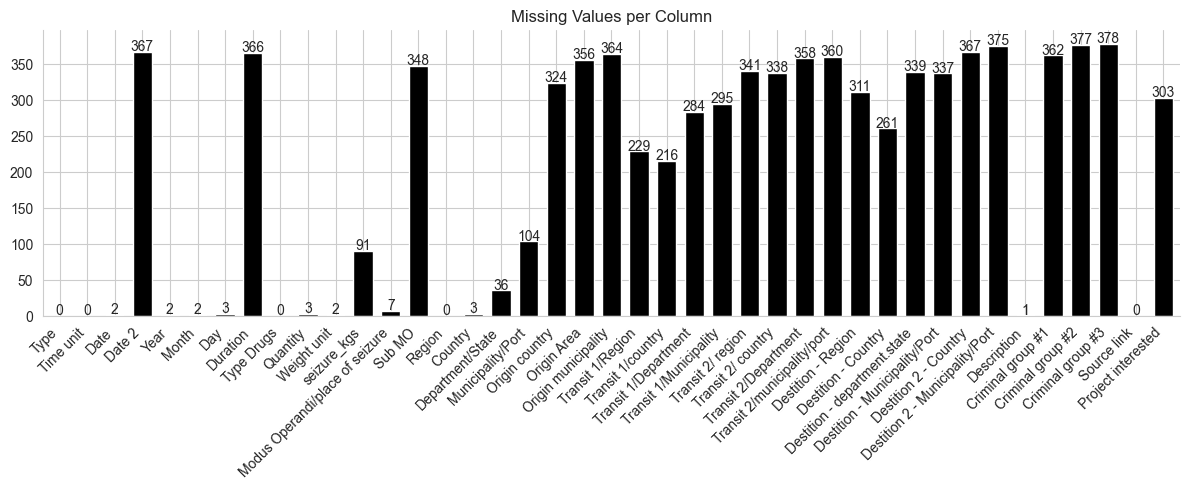

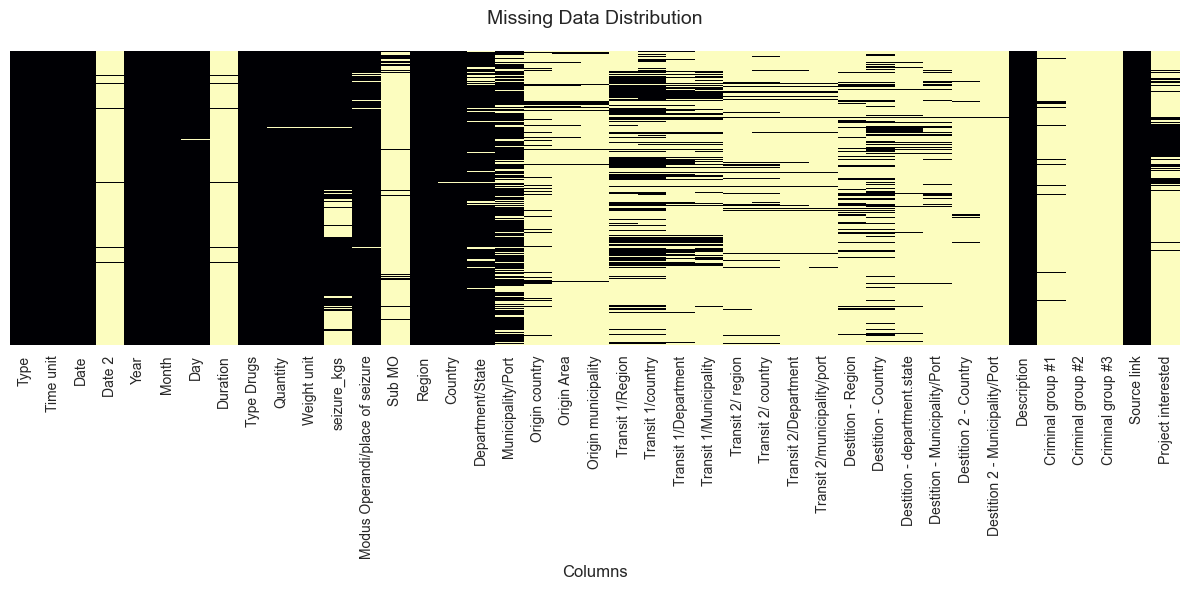

In [77]:
# Missing Data Analysis
missing_values = df.isnull().sum()
print(f"Missing values per column:\n{missing_values}")

# Visualization 1: Bars
plt.figure(figsize=(12, 5))
ax = missing_values.plot(kind='bar', color="#000000", width=0.7)

# Add numbers on top of bars
for i in ax.patches:
    ax.text(i.get_x() + i.get_width()/2, i.get_height()+1, 
            f'{int(i.get_height())}', 
            ha='center', fontsize=10)

plt.xticks(rotation=45, ha='right')
sns.despine()
plt.title("Missing Values per Column")
plt.tight_layout()

# Visualization 2: Heatmap (More Detailed)
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cmap='magma', cbar=False, yticklabels=False)
plt.title("Missing Data Distribution", fontsize=14, pad=20)
plt.xlabel("Columns", fontsize=12)
plt.tight_layout()
plt.show()

# Por trabajar

In [40]:
# Update column name directly in Google Sheets
def update_column_name(old_name, new_name):
    # Get headers
    headers = sheet.values().get(spreadsheetId=SPREADSHEET_ID, range='2025!1:1').execute()['values'][0]
    
    # Find and update column
    if old_name in headers:
        col_index = headers.index(old_name)
        col_letter = chr(65 + col_index)  # Convert to A, B, C...
        
        # Update in sheet
        sheet.values().update(
            spreadsheetId=SPREADSHEET_ID,
            range=f'2025!{col_letter}1',
            valueInputOption='RAW',
            body={'values': [[new_name]]}
        ).execute()
        
        print(f"✅ '{old_name}' → '{new_name}'")
    else:
        print(f"❌ '{old_name}' not found")

# Usage
update_column_name('Date-test', 'Date')

# Refresh DataFrame
result = sheet.values().get(spreadsheetId=SPREADSHEET_ID, range=RANGE_NAME).execute()
values = result.get('values', [])
df = pd.DataFrame(values[1:], columns=values[0])

✅ 'Date-test' → 'Date'


In [24]:
# Format date column to DD-MM-YYYY directly in Google Sheets
def format_dates_to_dd_mm_yyyy(date_column_name='Date'):
    # Get all data
    result = sheet.values().get(spreadsheetId=SPREADSHEET_ID, range=RANGE_NAME).execute()
    values = result.get('values', [])
    
    if not values:
        print("❌ No data found")
        return
    
    headers = values[0]
    if date_column_name not in headers:
        print(f"❌ '{date_column_name}' column not found")
        return
    
    col_index = headers.index(date_column_name)
    col_letter = chr(65 + col_index)
    
    # Process dates
    updated_values = []
    for i, row in enumerate(values[1:], 2):  # Start from row 2
        if col_index < len(row) and row[col_index]:
            try:
                # Parse date (assuming YYYY-MM-DD format)
                date_obj = datetime.strptime(row[col_index], "%Y-%m-%d")
                # Format to DD-MM-YYYY
                formatted_date = date_obj.strftime("%d-%m-%Y")
                updated_values.append([formatted_date])
            except ValueError:
                # Keep original if can't parse
                updated_values.append([row[col_index]])
        else:
            updated_values.append([''])
    
    # Update the entire date column
    if updated_values:
        sheet.values().update(
            spreadsheetId=SPREADSHEET_ID,
            range=f'2025!{col_letter}2:{col_letter}{len(updated_values)+1}',
            valueInputOption='RAW',
            body={'values': updated_values}
        ).execute()
        
        print(f"✅ Dates formatted to DD-MM-YYYY in column {col_letter}")

# Usage
format_dates_to_dd_mm_yyyy('Date')  # or whatever your date column is called

✅ Dates formatted to DD-MM-YYYY in column C


In [44]:
def enforce_time_unit_rule():
    # Get all data
    result = sheet.values().get(spreadsheetId=SPREADSHEET_ID, range=RANGE_NAME).execute()
    values = result.get('values', [])
    
    if not values:
        print("❌ No data found")
        return
    
    headers = values[0]
    
    # Find required columns
    try:
        time_unit_col = headers.index('Time unit')
        date2_col = headers.index('Date 2')
    except ValueError:
        print("❌ Required columns not found (Time unit and/or Date 2)")
        return
    
    # Prepare batch update requests
    requests = []
    violations = []
    
    for i, row in enumerate(values[1:], 2):  # Start from row 2 (1-indexed)
        # Check if row has enough columns
        if len(row) <= max(time_unit_col, date2_col):
            continue
            
        time_unit = row[time_unit_col].strip().lower() if time_unit_col < len(row) and row[time_unit_col] else None
        date2 = row[date2_col].strip() if date2_col < len(row) and row[date2_col] else None
        
        if time_unit == 'individual' and date2:
            violations.append(i)
            
            # Add request to clear the cell
            requests.append({
                'repeatCell': {
                    'range': {
                        'sheetId': SHEET_ID,  # You need to define this
                        'startRowIndex': i-1,  # 0-based
                        'endRowIndex': i,
                        'startColumnIndex': date2_col,
                        'endColumnIndex': date2_col+1
                    },
                    'cell': {
                        'userEnteredValue': {'stringValue': ''}
                    },
                    'fields': 'userEnteredValue'
                }
            })
            
            # Add request to format cell red
            requests.append({
                'repeatCell': {
                    'range': {
                        'sheetId': SHEET_ID,
                        'startRowIndex': i-1,
                        'endRowIndex': i,
                        'startColumnIndex': date2_col,
                        'endColumnIndex': date2_col+1
                    },
                    'cell': {
                        'userEnteredFormat': {
                            'backgroundColor': {
                                'red': 1,
                                'green': 0.8,
                                'blue': 0.8
                            }
                        }
                    },
                    'fields': 'userEnteredFormat.backgroundColor'
                }
            })
    
    # Execute batch update if there are violations
    if requests:
        body = {
            'requests': requests
        }
        sheet.batchUpdate(spreadsheetId=SPREADSHEET_ID, body=body).execute()
        print(f"✅ Rule enforced: {len(violations)} violations found and corrected")
        print(f"   Rows with violations: {violations}")
    else:
        print("✅ No violations found")

In [ ]:
# ✅ GATHER DROPDOWN OPTIONS FOR EACH COLUMN
dropdown_options = {}

for col in df.columns:
    unique_values = df[col].dropna().unique().tolist()
    dropdown_options[col] = unique_values

# Optional: Print a preview of the dropdown dictionary
for col, options in dropdown_options.items():
    print(f"{col}: {options[:10]}{'...' if len(options) > 10 else ''}")


{}

#### 4.3 Validation


#### 4.4 Reporting